In [39]:
from cuqi.distribution import DistributionGallery, Gaussian, JointDistribution
from cuqi.testproblem import Poisson1D
from cuqi.problem import BayesianProblem
import cuqi
import inspect
import numpy as np
import matplotlib.pyplot as plt
from cuqi.sampler import MH, CWMH, ULA, MALA, NUTS
import time
import scipy.stats as sps
from scipy.stats import gaussian_kde

In [40]:
# The donut distribution 
target_donut = DistributionGallery("donut")

# The Poisson1D Bayesian problem
dim = 201
L = np.pi

xs = np.array([0.2, 0.4, 0.6, 0.8])*L
ws = 0.8
sigma_s = 0.05
def f(t):
    s = np.zeros(dim-1)
    for i in range(4):
        s += ws * sps.norm.pdf(t, loc=xs[i], scale=sigma_s)
    return s

A, _, _ = Poisson1D(dim=dim, 
                    endpoint=L,
                    field_type='KL',
                    field_params={'num_modes': 10} ,
                    map=lambda x: np.exp(x), 
                    source=f).get_components()
sigma_x = 30
x = Gaussian(0, sigma_x**2, geometry=A.domain_geometry)
np.random.seed(12)
x_true = x.sample()
sigma_y = np.sqrt(0.001)
y = Gaussian(A(x), sigma_y**2, geometry=A.range_geometry)
y_obs = y(x=x_true).sample()
joint = JointDistribution(y, x)
target_poisson = joint(y=y_obs)

In [3]:
def plot2d(val, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    # plot
    pixelwidth_x = (x1_max-x1_min)/(N2-1)
    pixelwidth_y = (x2_max-x2_min)/(N2-1)

    hp_x = 0.5*pixelwidth_x
    hp_y = 0.5*pixelwidth_y

    extent = (x1_min-hp_x, x1_max+hp_x, x2_min-hp_y, x2_max+hp_y)

    plt.imshow(val, origin='lower', extent=extent, **kwargs)
    plt.colorbar()


def plot_pdf_2D(distb, x1_min, x1_max, x2_min, x2_max, N2=201, **kwargs):
    N2 = 201
    ls1 = np.linspace(x1_min, x1_max, N2)
    ls2 = np.linspace(x2_min, x2_max, N2)
    grid1, grid2 = np.meshgrid(ls1, ls2)
    distb_pdf = np.zeros((N2,N2))
    for ii in range(N2):
        for jj in range(N2):
            distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]]))) 
    plot2d(distb_pdf, x1_min, x1_max, x2_min, x2_max, N2, **kwargs)

def plot_pdf_1D(distb, min, max, **kwargs):
    grid = np.linspace(min, max, 1000)
    y = [distb.pdf(grid_point) for grid_point in grid]
    plt.plot(grid, y, **kwargs)

In [4]:
[sampler for sampler in dir(cuqi.sampler) if not sampler.startswith('_')]

['CWMH',
 'Conjugate',
 'ConjugateApprox',
 'Gibbs',
 'LinearRTO',
 'MALA',
 'MH',
 'NUTS',
 'ProposalBasedSampler',
 'RegularizedLinearRTO',
 'Sampler',
 'UGLA',
 'ULA',
 'pCN']

In [41]:
Ns = 10000 # Number of samples
Nb = 0 # Number of burn-in samples
scale = 0.05 # Fixed step size "scale"

In [42]:
MH_sampler = MH(target_donut, scale=scale, x0=np.array([0,0]))

In [43]:
start = time.time()
MH_fixed_samples = MH_sampler.sample(Ns, Nb)
end_fixed = time.time() - start  


Sample 10000 / 10000

Average acceptance rate: 0.8742 



In [57]:
#ess arviz diagnostic 
import arviz
arviz.ess(MH_fixed_samples.to_arviz_inferencedata())



<xarray.Dataset> Size: 16B
Dimensions:  ()
Data variables:
    v0       float64 8B 10.02
    v1       float64 8B 1.657

In [48]:
MH_fixed_samples.compute_ess()

array([10.02117011,  1.65705179])

In [55]:
#rhat arviz diagnostic 
az.rhat(data, var_names=["mu", "theta_t"], method="folded")
data = arviz.load_arviz_data("non_centered_eight")
arviz.rhat(data)

<xarray.Dataset> Size: 656B
Dimensions:  (school: 8)
Coordinates:
  * school   (school) <U16 512B 'Choate' 'Deerfield' ... 'Mt. Hermon'
Data variables:
    mu       float64 8B 1.003
    theta_t  (school) float64 64B 1.0 1.001 0.9997 1.001 ... 1.004 0.9992 1.002
    tau      float64 8B 1.003
    theta    (school) float64 64B 1.003 0.9992 1.003 1.001 ... 1.002 1.001 1.003

C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

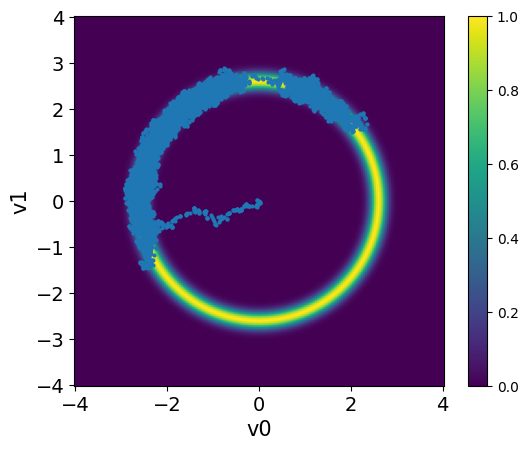

In [81]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
MH_fixed_samples.plot_pair(ax=plt.gca())

In [82]:
#MH_fixed_samples.burnthin(2)

In [83]:
MH_sampler.scale = 0.05

In [84]:
Ns = 8500
Nb = 1500
start = time.time()

#MH_fixed_samples = MH_sampler.sample(Ns, Nb)
end_fixed = time.time() - start  
MH_adapted_samples = MH_sampler.sample_adapt(Ns, Nb)
end_adapted = time.time() - start 

Sample 10000 / 10000

Average acceptance rate: 0.5031764705882353 MCMC scale: 0.38714114065164923 



In [85]:
print(end_adapted)
print(end_fixed)
type(MH_adapted_samples)

2.1841490268707275
0.0


cuqi.samples._samples.Samples

C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

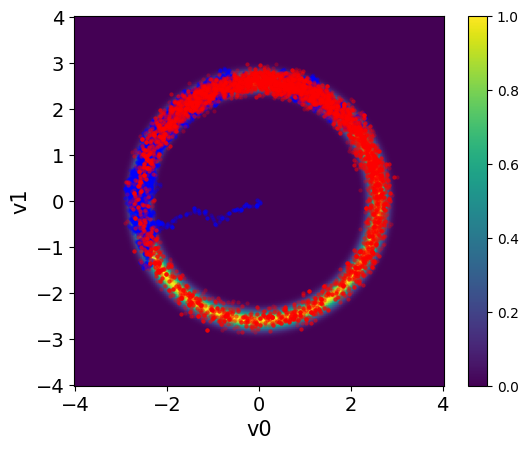

In [86]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
MH_fixed_samples.plot_pair(ax=plt.gca(),scatter_kwargs={'c':'b', 'alpha':0.3})
MH_adapted_samples.plot_pair(ax=plt.gca(),scatter_kwargs={'c':'r', 'alpha':0.3})

In [87]:
MH_fixed_samples.compute_ess()/end_fixed

C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\177200036.py:1: RuntimeWarning: divide by zero encountered in divide
  MH_fixed_samples.compute_ess()/end_fixed


array([inf, inf])

In [88]:
MH_adapted_samples.compute_ess()/end_adapted

array([3.08486884, 6.10611361])

array([[<Axes: title={'center': 'v0'}>, <Axes: title={'center': 'v0'}>],
       [<Axes: title={'center': 'v1'}>, <Axes: title={'center': 'v1'}>]],
      dtype=object)

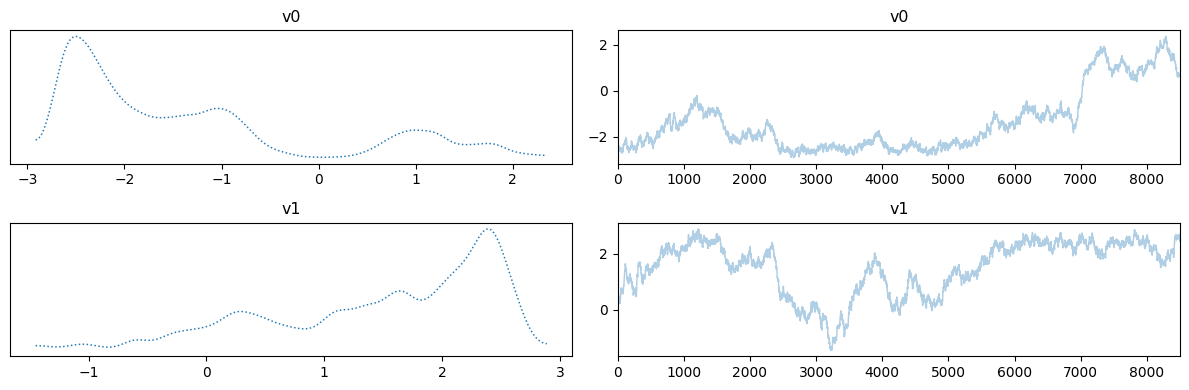

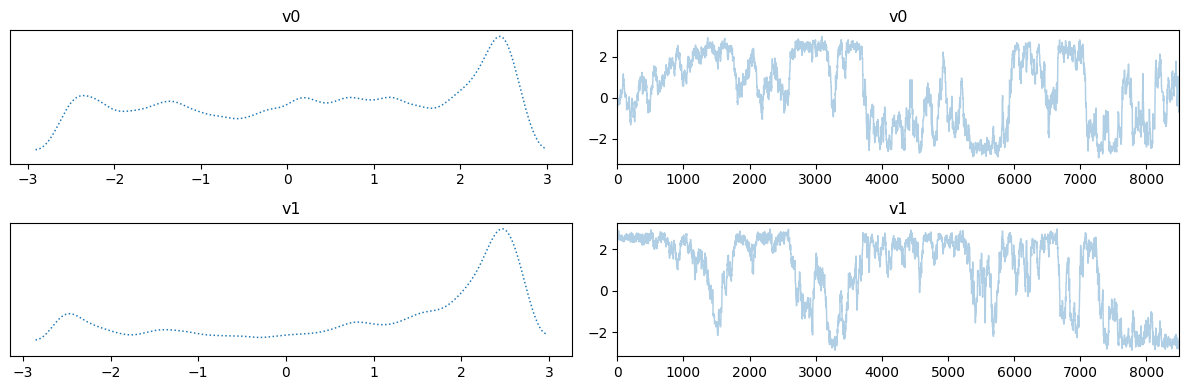

In [89]:
MH_fixed_samples.burnthin(1500).plot_trace()
MH_adapted_samples.plot_trace()

array([[<Axes: >, None],
       [<Axes: xlabel='v0', ylabel='v1'>, <Axes: >]], dtype=object)

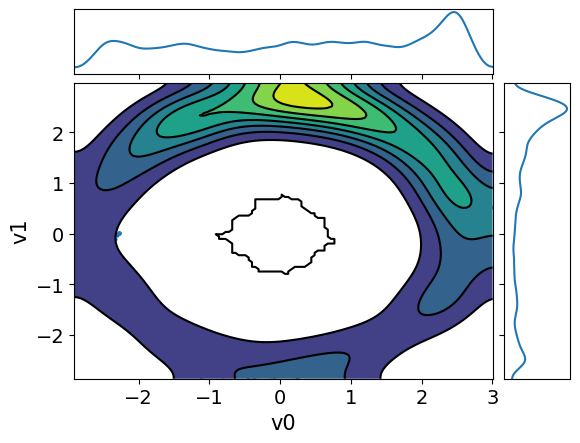

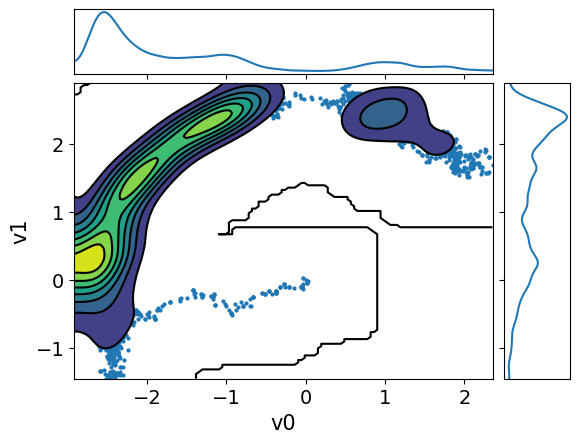

In [90]:
MH_adapted_samples.plot_pair(kind=["scatter", "kde"], kde_kwargs={"fill_last": False}, marginals=True)
MH_fixed_samples.plot_pair(kind=["scatter", "kde"], kde_kwargs={"fill_last": False}, marginals=True)

## Chapter 3

In [97]:
ULA_sampler = ULA(target=target_donut, scale=0.065, x0=np.array([0,0]))

In [92]:
Ns = 1000
ULA_samples = ULA_sampler.sample(Ns)

Sample 1000 / 1000


C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

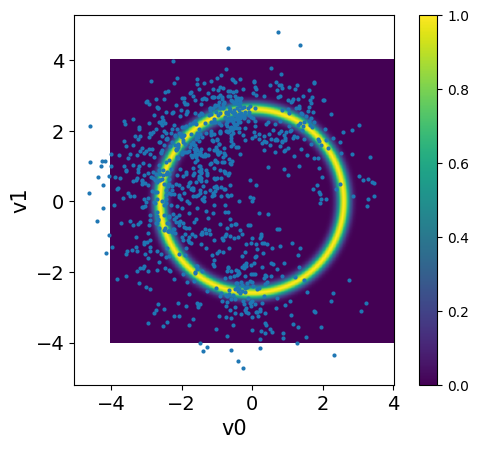

In [96]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
ULA_samples.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1})

In [128]:
ULA_sampler1 = ULA(target=target_donut, scale=0.001, x0=np.array([0,0]))
Ns = 10
ULA_samples1 = ULA_sampler1.sample(Ns)

Sample 10 / 10


C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

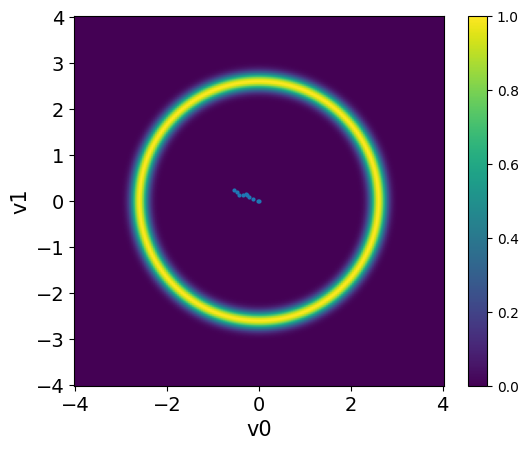

In [129]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
ULA_samples1.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1})

In [130]:
MH_10 = MH(target_donut, scale=0.01, x0=np.array([0, 0]))

In [131]:
MH_10_samples = MH_10.sample(10, 0)

Sample 10 / 10

Average acceptance rate: 0.8 



<Axes: xlabel='v0', ylabel='v1'>

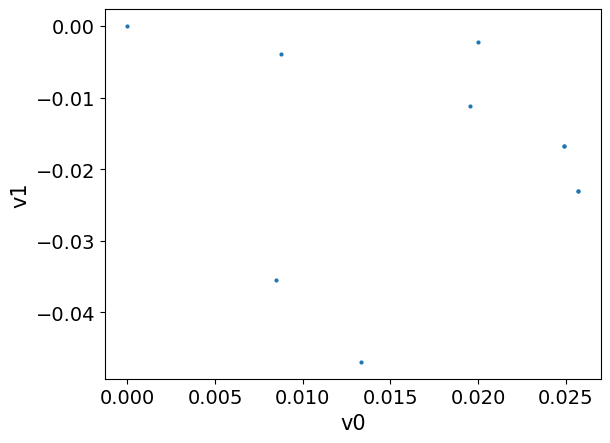

In [132]:
MH_10_samples.plot_pair()

C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


<Axes: xlabel='v0', ylabel='v1'>

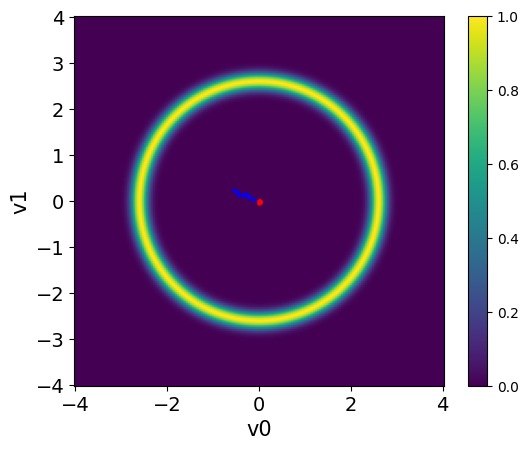

In [135]:

plot_pdf_2D(target_donut, -4, 4, -4, 4)
ULA_samples1.plot_pair(ax=plt.gca(),scatter_kwargs={'c':'b', 'alpha':1})
MH_10_samples.plot_pair(ax=plt.gca(),scatter_kwargs={'c':'r', 'alpha':1})

In [136]:
x_uni = Gaussian(0,1)

In [141]:
ULA_uni=ULA(x_uni, scale = 1, x0 = 0)

In [142]:
ULA_uni_samples = ULA_uni.sample(4000)

Sample 4000 / 4000


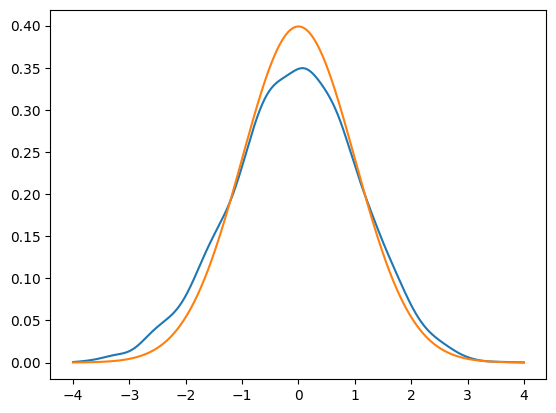

In [155]:
kde_est = gaussian_kde(ULA_uni_samples.samples[0,:])

grid = np.linspace(-4, 4, 1000)
plt.plot(grid, kde_est(grid))
plot_pdf_1D(x_uni, -4, 4)

## Chapter 4

x_uni = Gaussian(0, 1)

In [156]:
x_uni = Gaussian(0, 1)

In [157]:
MALA_uni = MALA(x_uni, scale=1, x0=0)

Ns = 40000
ULA_samples_uni = MALA_uni.sample(Ns)

Sample 40000 / 40000


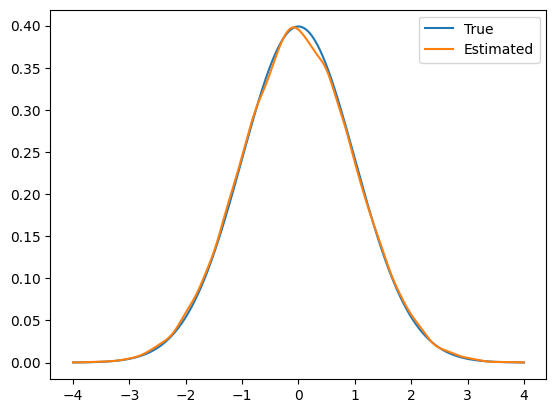

In [158]:
plot_pdf_1D(x_uni, -4, 4, label='True')
grid = np.linspace(-4, 4, 1000)
kde_est = gaussian_kde(ULA_samples_uni.samples[0,:])
plt.plot(grid, kde_est(grid), label='Estimated')
plt.legend()

# Chapter 5

In [164]:
NUTS_donut = NUTS(target=target_donut, x0=np.array([0,0]))

In [169]:
Ns = 100
Nb = 2
NUTS_donuts_samples = NUTS_donut.sample(Ns, Nb)

Sample 102 / 102


C:\Users\Ich\AppData\Local\Temp\ipykernel_28452\1564103046.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  distb_pdf[ii,jj] = np.exp(distb.logd(np.array([grid1[ii,jj], grid2[ii,jj]])))


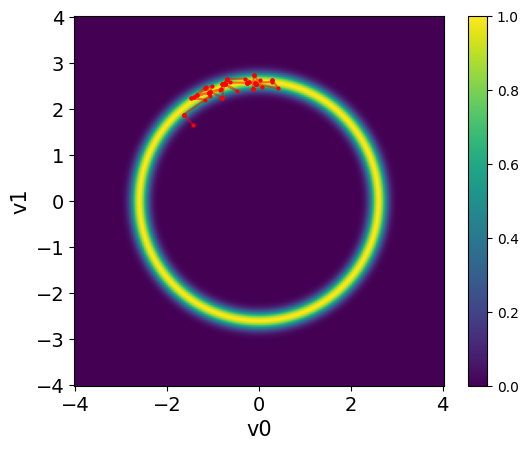

In [170]:
plot_pdf_2D(target_donut, -4, 4, -4, 4)
NUTS_donuts_samples.plot_pair(ax=plt.gca(), scatter_kwargs={'alpha': 1, 'c': 'r'})
plt.plot(NUTS_donuts_samples.samples[0,:], NUTS_donuts_samples.samples[1,:], 'r', alpha=0.5)

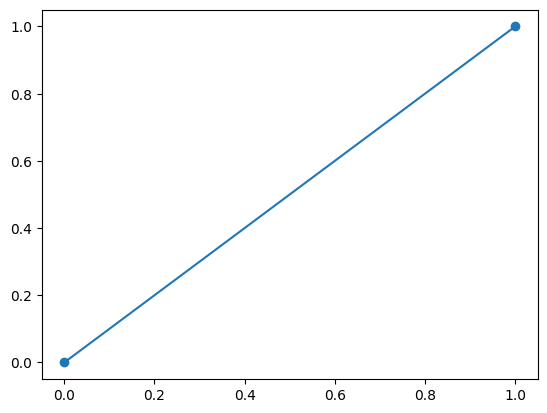

In [38]:
plt.scatter(np.linspace(0,1,2), np.linspace(0,1,2))
plt.plot(np.linspace(0,1,2), np.linspace(0,1,2))
